In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd


In [ ]:
ID = 999
PATH = os.path.join('ISIC-images',f'ISIC_{ID:07}.jpg')
# Loading image
img = cv.imread(PATH, cv.IMREAD_GRAYSCALE)

In [146]:
def plot_images(images, titles=None, cols=3, figsize=(10, 5)):
    """
    Plots a list of images using Matplotlib.

    Parameters:
    - images: List of NumPy arrays (each image should be in grayscale or RGB format).
    - titles: List of titles corresponding to each image (default is None).
    - cols: Number of columns in the subplot grid (default is 3).
    - figsize: Tuple specifying figure size (default is (10, 5)).
    """
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'gray' if len(img.shape) == 2 else None
        plt.imshow(img, cmap=cmap)
        plt.axis('off')  # Hide axes
        
        if titles and i < len(titles):
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()

Filtering:
1. Reduce noise
2. determine noise reduction target
3. detect and remove hair
4. heal skin damage

- non-local averaging
- block-matching 3D filters

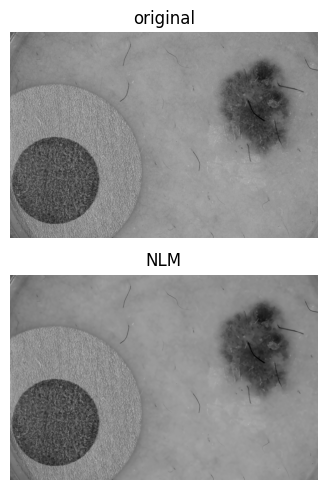

In [147]:
# Using non-local averaging
denoised = cv.fastNlMeansDenoising(img, h=10, templateWindowSize=7, searchWindowSize=21)

# block matching 3D filters

plot_images(np.array([img, denoised]),["original", "NLM"], cols=1)

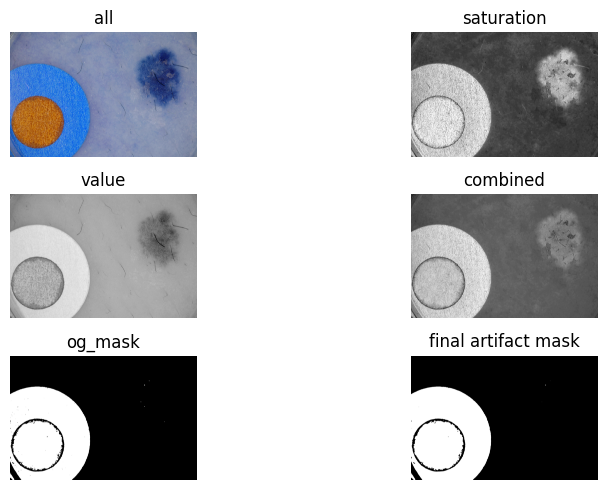

In [152]:
coloured = cv.imread(PATH)
hsv = cv.cvtColor(coloured, cv.COLOR_BGR2HSV)

# Separating based on hue, saturation, value
hue, saturation, value = cv.split(hsv)

# adding saturation and value together
# this is because there are images with bright + saturated stickers. If we only go by saturation, it'll highlight both the sticker + spot, we need to add value as well because the leision is usually not as bright and saturated as the sticker.
combined = cv.addWeighted(saturation, 0.5, value, 0.5, 0)
combined = combined.astype(np.uint8)

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(7,7))
opening = cv.morphologyEx(combined, cv.MORPH_OPEN, kernel)
blur = cv.GaussianBlur(opening,(5,5),0)
_, mask = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
artifact_mask = cv.medianBlur(mask,11)
artifact_mask
plot_images([coloured, saturation, value, combined, mask, artifact_mask],["all", "saturation", "value", "combined", "og_mask", "final artifact mask"], cols=2)



Combining masks together

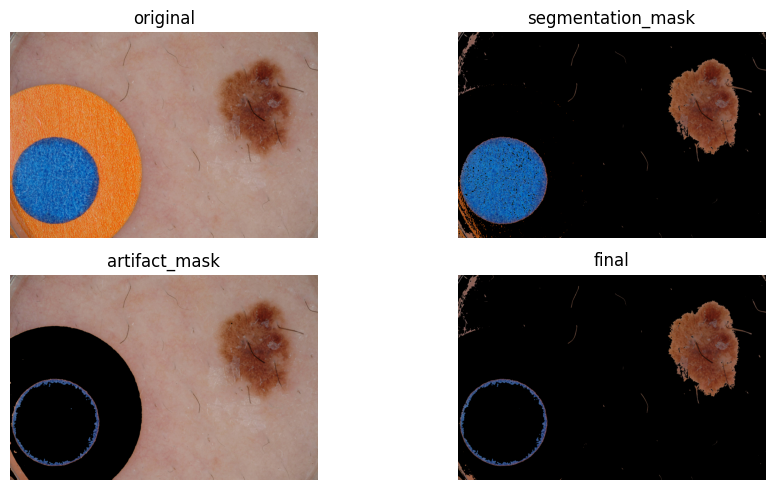

: 

In [ ]:
blur = cv.GaussianBlur(img,(5,5),0)
_,segmentation_mask = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

or_mask = cv.bitwise_not(cv.bitwise_or(segmentation_mask, artifact_mask))

original_image = cv.imread(PATH, cv.IMREAD_COLOR_RGB)
segmentation = cv.bitwise_and(original_image, original_image, mask=cv.bitwise_not(segmentation_mask))
artifact = cv.bitwise_and(original_image, original_image, mask=cv.bitwise_not(artifact_mask))
final = cv.bitwise_and(original_image, original_image, mask=or_mask)
plot_images([original_image, segmentation, artifact, final],["original", "segmentation_mask","artifact_mask", "final"], cols=2)